In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read

abtem.config.set({"local_diagnostics.progress_bar": True});

(walkthrough:partial_coherence)=
# Partial coherence

In our [walkthrough on the contrast transfer function](walkthrough:contrast_transfer_function), we described how partial coherence may be approximated by multiplication with an envelope function. This approach is not always appropriate for simulating experiments with plane wave illumination and it is never appropriate for simulating experiments with a convergent beam. In this walkthrough, we cover the more accurate approach 

## Partial coherence with plane waves

When imagaing with plane waves, partial temporal coherence (due to energy spread) is generally more important than partial spatial coherence (due to source size), this is true even with a chromatic aberration corrector[]. For this reason our walkthrough will focus on partial temporal coehrence. We aim to compare the quasicoherent approximation to the accurate incoherent summation.

As a test system, we simulate an exit wave at $80 \ \mathrm{keV}$ using a sample of MoS<sub>2</sub>.

In [9]:
exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.05).multislice(
    ase.build.mx2(vacuum=2)
)

Next we apply a contrast transfer function using the Scherzer defocus with a spherical aberration of $-20 \ \mu m$ and a focal spread of $50 \ \mathrm{Å}$. See the [walkthrough on the CTF](walkthrough:contrast_transfer_function) for details.

In [3]:
energy = 80e3
Cs = -20e-6 * 1e10

# Simulate image with coherent 
ctf_coherent = abtem.CTF(Cs=Cs, energy=80e3)
ctf_coherent.defocus = ctf_coherent.scherzer_defocus
ctf_coherent.semiangle_cutoff = ctf_coherent.crossover_angle
image_coherent = exit_wave.apply_ctf(ctf_coherent).intensity().compute()



focal_spread = 50

# Create CTF with temporal coherence envelope
ctf_quasi_coherent = ctf_coherent.copy()
ctf_quasi_coherent.focal_spread = focal_spread

# Run multislice and get intensity

image_quasi_coherent = exit_wave.apply_ctf(ctf_quasi_coherent).intensity()


image_quasi_coherent.compute()

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.1s


In the fully incoherent model of partial temporal coherence, we integrate over images at different defocii 

$$
    I_{incoherent} = \int_{-\infty}^{\infty} p(\Delta f) I(\Delta f) \ \mathrm{d} \Delta f \quad ,
$$

the image intensity given an exit wave function, $\psi_{exit}$, and the phase aberrations, $\chi(\Delta f)$, with the defocus, $\Delta f$, may be written

$$
    I(\Delta f) = \left\| \mathcal{F^{-1}}\left[ \hat{\psi}_{exit} \exp(-i \chi(\Delta f) \right] \right\|^2 \quad ,
$$

where for clarity we have omitted both real and reciprocal space coordinates. 

The weighting function is assumed to be Gaussian

$$
    p(\Delta f) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{(\Delta f_{center} - \Delta f) ^ 2}{2\sigma ^ 2}\right)
$$

where $\sigma$ is the focal spread (equivalent to `focal_spread` in the quasi-coherent model).

We approximate Eq. as a Riemann sum

$$
    I_{incoherent} = \sum_{\Delta f_n} p(\Delta f_n) I(\Delta f_n)
$$

where we need to choose a set of $N$ samples 

$$
    \Delta f_n = \Delta f_{center} - \Delta f_{truncation} + \frac{2 n \Delta f_{truncation}}{N}
$$

where $n=0,1,\ldots,N$ and the truncation of the sum, $\Delta f_{truncation}$, have to be chosen such that $p(\Delta f)$ is small.

In [4]:
ctf_incoherent = ctf_coherent.copy()

defocus = abtem.distributions.gaussian(
    center=ctf_incoherent.defocus,
    standard_deviation=focal_spread,
    num_samples=7,
    sampling_limit=1.5,
)

ctf_incoherent.defocus = defocus

In [6]:
images_incoherent = exit_wave.apply_ctf(ctf_incoherent).intensity()

images_incoherent.compute()

[########################################] | 100% Completed |  0.1s


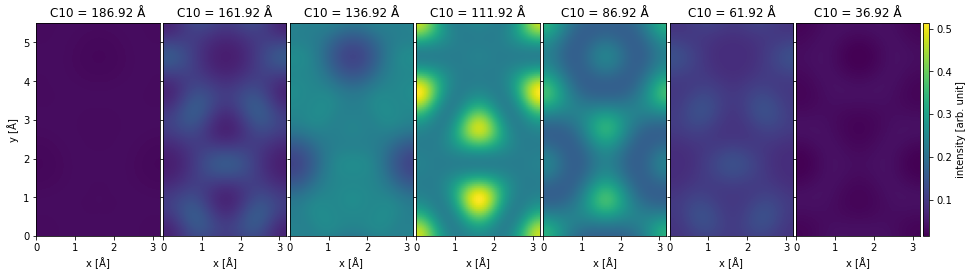

In [7]:
images_incoherent.show(
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

In [49]:
image_incoherent = images_incoherent.sum(0)

stack = abtem.stack(
    [image_coherent, image_quasi_coherent, image_incoherent],
    ("coherent", "quasi-coherent", "incoherent"),
)

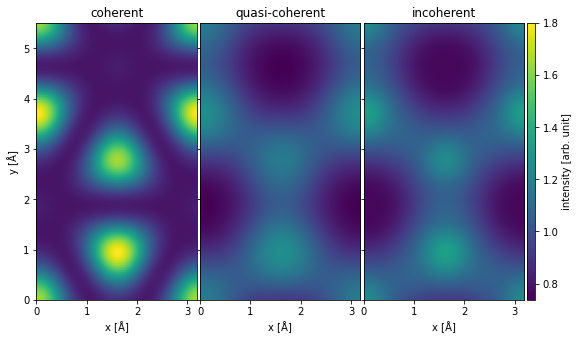

In [50]:
stack.show(
    common_color_scale=True,
    explode=True,
    cbar=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

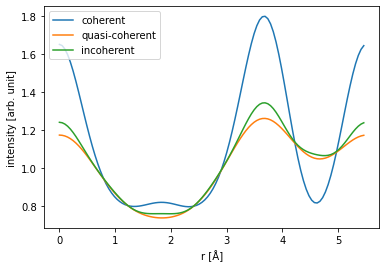

In [51]:
stack.interpolate_line(start=(0, 0), end=(0, stack.extent[1])).show();

## Partial coherence with probes

We see that 


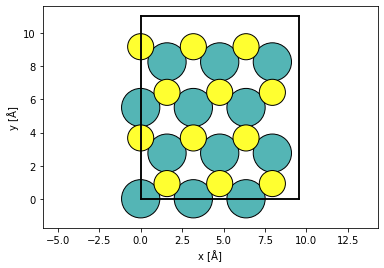

In [52]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms) * (3, 2, 1)

abtem.show_atoms(atoms);

In [58]:
energy = 80e3
source_size = 0.3
charomatic_aberration = 1.0 * 1e-3 * 1e10
energy_spread = 0.15
focal_spread = charomatic_aberration * energy_spread / energy

defocus_distribution = abtem.distributions.gaussian(
    center=0.0,
    standard_deviation=focal_spread,
    num_samples=11,
    sampling_limit=2,
    ensemble_mean=False,
)

In [69]:
probe_coherent = abtem.Probe(energy=energy, semiangle_cutoff=30, sampling=0.05)
probe_temporal = abtem.Probe(
    energy=energy, semiangle_cutoff=30, sampling=0.05, defocus=defocus_distribution
)

detector = abtem.PixelatedDetector()

scan = abtem.GridScan.from_fractional_coordinates(
    atoms,
    (0, 0),
    (1 / 3, 1 / 2),  # sampling=0.15
)

measurement_coherent = probe_coherent.scan(
    atoms, detectors=detector, scan=scan
).compute()

measurement_temporal = probe_temporal.scan(
    atoms, detectors=detector, scan=scan
).compute()

[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed | 13.4s


Partial spatial coherence is added using the `gaussian_source_size` method which applies a gaussian blur accross the scan dimensions. We emphasize that we do not blur individual diffraction patterns, rather we mix adjacent diffraction patterns weighted by a gaussian as a function of the distance between the probe position at which the pattern was collected.

In [82]:
measurement_spatial = measurement_coherent.gaussian_source_size(source_size)
measurement_temporal_spatial = measurement_temporal.gaussian_source_size(source_size)

We stack the `DiffractionPatterns` for more convenient plotting.

In [83]:
stacked = abtem.stack(
    (
        measurement_coherent,
        measurement_temporal,
        measurement_spatial,
        measurement_temporal_spatial,
    ),
    ("coherent", "temporal", "spatial", "temporal + spatial"),
)

We select the diffraction patterns with the index `(1, 1)`, i.e. the patterns collected to the upper right of the Mo atom. We crop the diffraction patterns to just above the bright field disk and plot them on an exploded plot.

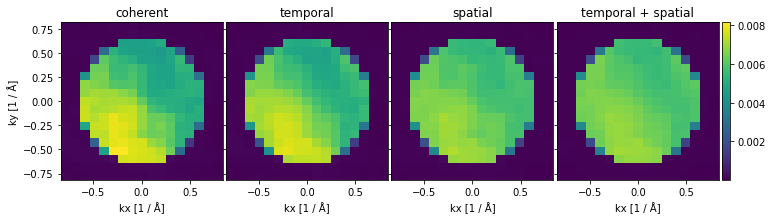

In [95]:
stacked[:, 1, 1].crop(35).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

It is immediately clear that partial coherence reduces the contrast in the diffraction patterns. 

Next we show the medium angle scattering intensity. It should be noted that the order in which the the `integrate_radial` and the `gaussian_source_size` methods are applied does not matter.

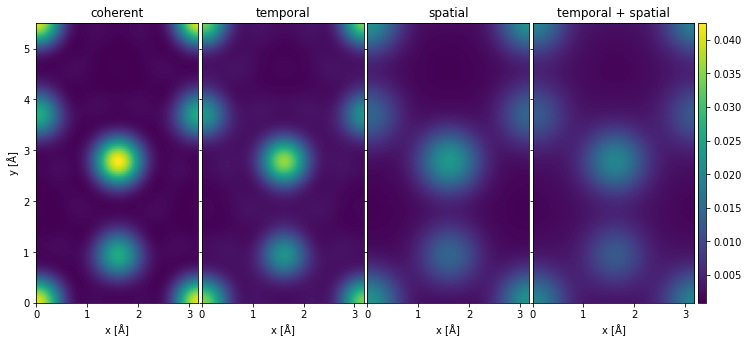

In [94]:
stacked.integrate_radial(50, 150).interpolate(0.05).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

Finally we show the absolute value 

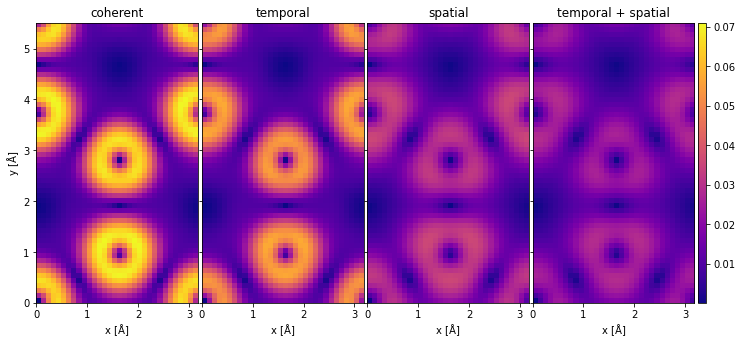

In [89]:
stacked.center_of_mass().interpolate(0.1).abs().show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
    cmap="plasma",
);

The preceding results show that partial spatial coherence is very important, we see that it both lowers the contrast and generally changes both the integrated and COM images. Partial temporal coherence, even at this low energy, had a less important role and its main main contribution was to lower the contrast. We should also note that the cost of including partial spatial coherence is almost non-existent, whereas partial temporal coherence may give a $\sim 10 x$ overhead.
